# 데이터 전처리 코드 모음

### 특성 제거 코드 drop_feature.py

In [1]:
# 상관관계가 낮은 ex_temperature', 'PM1.0', 'PM10', 'ex_humidity', 'ex_illuminance 제거
import os
import pandas as pd

# 현재 작업 디렉토리 확인 (Jupyter 환경에서는 이게 기준)
current_dir = os.getcwd()
csv_path = os.path.join("..", "data", "V_data.csv")

# 파일 읽기
df = pd.read_csv(csv_path)

# 제거할 컬럼 (상관관계 낮음)
drop_columns = ['ex_temperature', 'PM1.0', 'PM10', 'ex_humidity', 'ex_illuminance']

# 컬럼 제거
filtered_df = df.drop(columns=drop_columns)

# 새 파일로 저장
save_path = os.path.join(current_dir, "..", "data", "V_f_data.csv")
filtered_df.to_csv(save_path, index=False)

print("불필요한 컬럼 제거 완료. 저장 경로:", save_path)


불필요한 컬럼 제거 완료. 저장 경로: /Users/kwonminseok/Desktop/semiconductor_tcn_project/notebooks/../data/V_f_data.csv


### 시간 그래프 확인 

/var/folders/6_/gfrk7lt15d79q76hpjbm56ph0000gn/T/ipykernel_8207/3863227267.py:25: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/gfrk7lt15d79q76hpjbm56ph0000gn/T/ipykernel_8207/3863227267.py:25: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/gfrk7lt15d79q76hpjbm56ph0000gn/T/ipykernel_8207/3863227267.py:25: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/gfrk7lt15d79q76hpjbm56ph0000gn/T/ipykernel_8207/3863227267.py:25: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/gfrk7lt15d79q76hpjbm56ph0000gn/T/ipykernel_8207/3863227267.py:25: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/gfrk7lt15d79q76hpjbm56ph0000gn/T/ipykernel_82

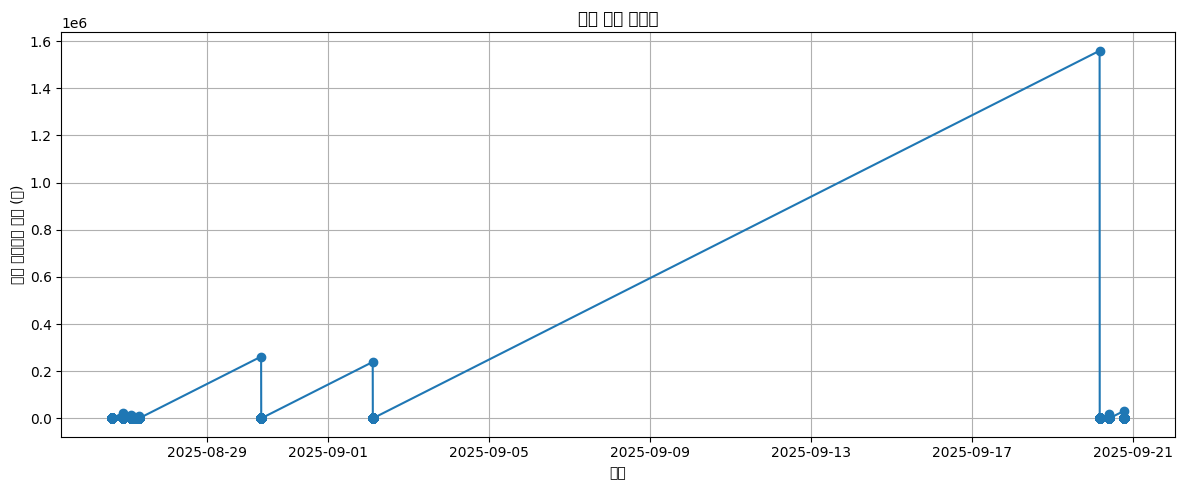

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Jupyter에서 실행: notebooks/ 기준 -> 상위 data/ 폴더 접근
csv_path = os.path.join("..", "data", "V_f_data.csv")
df = pd.read_csv(csv_path)

# 날짜와 시간 컬럼 합치기 (문자열 결합 후 datetime 변환)
df['timestamp'] = pd.to_datetime(df['collection_date'] + ' ' + df['collection_time'])

# 시간순 정렬
df = df.sort_values('timestamp')

# 시간 간격 계산 (단위: 초)
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()

# 그래프 그리기
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['time_diff'], marker='o', linestyle='-')
plt.title("시간 간격 시각화")
plt.xlabel("시간")
plt.ylabel("이전 측정과의 간격 (초)")
plt.grid(True)
plt.tight_layout()
plt.show()


### collection_date + collection_time = datetime 변환 코드

In [3]:
import pandas as pd
import os

# 파일 경로 설정 (현재 경로 기준)

# Jupyter에서 실행: notebooks/ 기준 -> 상위 data/ 폴더 접근
csv_path = os.path.join("..", "data", "V_f_data.csv")
df = pd.read_csv(csv_path)

# 데이터 불러오기
df = pd.read_csv(csv_path)

# 날짜 + 시간 → timestamp 생성
df['timestamp'] = pd.to_datetime(df['collection_date'].astype(str) + ' ' + df['collection_time'])

# 시간순 정렬
df = df.sort_values('timestamp').reset_index(drop=True)

# 새로운 CSV로 저장
save_path = os.path.join(current_dir, "..", "data", "V_f_t.csv")
df.to_csv(save_path, index=False)

print("timestamp 열 추가 및 저장 완료. 경로:", save_path)


timestamp 열 추가 및 저장 완료. 경로: /Users/kwonminseok/Desktop/semiconductor_tcn_project/notebooks/../data/V_f_t.csv


### 시계열 구간확인

In [4]:
import pandas as pd

def find_continuous_sequences(df, interval_sec=1, tolerance=0.1, min_length=10):
    """
    시간 간격이 일정한 연속된 시계열 구간들을 식별합니다.

    Parameters:
    - df: timestamp 열이 포함된 DataFrame (정렬되어 있어야 함)
    - interval_sec: 기대하는 시간 간격 (초)
    - tolerance: 허용 오차 비율 (기본 ±10%)
    - min_length: 연속 구간 최소 길이 (이보다 짧으면 무시)

    Returns:
    - 구간 정보 리스트: [(start_idx, end_idx, 시작시간, 끝시간, 길이), ...]
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['time_diff'] = df['timestamp'].diff().dt.total_seconds().fillna(0)

    lower = interval_sec * (1 - tolerance)
    upper = interval_sec * (1 + tolerance)

    sequences = []
    start_idx = 0

    for i in range(1, len(df)):
        if not (lower <= df.loc[i, 'time_diff'] <= upper):
            if i - start_idx >= min_length:
                sequences.append((
                    start_idx,
                    i - 1,
                    df.loc[start_idx, 'timestamp'],
                    df.loc[i - 1, 'timestamp'],
                    i - start_idx
                ))
            start_idx = i

    # 마지막 구간 체크
    if len(df) - start_idx >= min_length:
        sequences.append((
            start_idx,
            len(df) - 1,
            df.loc[start_idx, 'timestamp'],
            df.loc[len(df) - 1, 'timestamp'],
            len(df) - start_idx
        ))

    return sequences


In [5]:
csv_path = os.path.join("..", "data", "V_f_t.csv")
df = pd.read_csv(csv_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
print(df['time_diff'].describe())

seqs = find_continuous_sequences(df, interval_sec=1, tolerance=0.1, min_length=50)

for s in seqs:
    print(f"구간: index {s[0]} ~ {s[1]}, 시간: {s[2]} ~ {s[3]}, 길이: {s[4]}개")


count    4.211000e+03
mean     5.156699e+02
std      2.465207e+04
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.559363e+06
Name: time_diff, dtype: float64
구간: index 0 ~ 300, 시간: 2025-08-26 15:21:38 ~ 2025-08-26 15:26:38, 길이: 301개
구간: index 301 ~ 601, 시간: 2025-08-26 21:55:48 ~ 2025-08-26 22:00:48, 길이: 301개
구간: index 602 ~ 901, 시간: 2025-08-27 02:23:24 ~ 2025-08-27 02:28:23, 길이: 300개
구간: index 902 ~ 1201, 시간: 2025-08-27 02:56:05 ~ 2025-08-27 03:01:04, 길이: 300개
구간: index 1202 ~ 1502, 시간: 2025-08-27 04:44:00 ~ 2025-08-27 04:49:00, 길이: 301개
구간: index 1503 ~ 1803, 시간: 2025-08-27 07:23:25 ~ 2025-08-27 07:28:25, 길이: 301개
구간: index 1804 ~ 2104, 시간: 2025-08-30 08:14:01 ~ 2025-08-30 08:19:01, 길이: 301개
구간: index 2105 ~ 2405, 시간: 2025-09-02 02:45:08 ~ 2025-09-02 02:50:08, 길이: 301개
구간: index 2406 ~ 2706, 시간: 2025-09-20 03:59:31 ~ 2025-09-20 04:04:31, 길이: 301개
구간: index 2707 ~ 3007, 시간: 2025-09-20 04:12:08 ~ 2025-09-20 04:17:08, 길이: 301개
구간: index 3

### drop_column.py 'device_name', 'collection_date', 'collection_time' 삭제

In [6]:
import pandas as pd
import os

# Jupyter에서 실행: notebooks/ 기준 -> 상위 data/ 폴더 접근
# 파일 경로 지정
input_path = os.path.join("..", "data", "V_f_t.csv")
output_path = os.path.join(current_dir, "..", "data", "V_f_t_d.csv")

# 삭제할 컬럼들
columns_to_drop = ['device_name', 'collection_date', 'collection_time']

# 실행
df = pd.read_csv(input_path)
df = df.drop(columns=columns_to_drop, errors='ignore')
df.to_csv(output_path, index=False)

print(f"[✅] 저장 완료 → {output_path}")


[✅] 저장 완료 → /Users/kwonminseok/Desktop/semiconductor_tcn_project/notebooks/../data/V_f_t_d.csv
